## Run Script before using Notebook
The run_before_notes.py. This helps notebooks picks packages as `__init__.py`

In [1]:
%run ./run_before_notes.py

Notebooks Import Ready


In [2]:
'''
Simple way of using selenium to get LinkedIn Connection Name and Title (Prototyping)
'''

from collections import defaultdict
import json
import logging
import os
import re
import time

from bs4 import BeautifulSoup, element as bs4_element
import numpy as np
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from utils import helpers

In [3]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO)

In [4]:
class LinkedIn:
    '''
    '''
    
    def __init__(self, snooze=2):

        self.login = False
        self.message_window_is_miminized = False
        logging.info('Setting Up LinkedIn')
        self.snooze = snooze

    def __repr__(self):
        
        if self.login:
            self._LinkedIn__my_profile()
            show = f'[On] LinkedIn({repr(self.my_name)})'
        else:
            show = '[Off] LinkedIn()'

        return show

        

    def __enter__(self):

        return self

    def __exit__(self, exc_type, exc_value, traceback):

        self.driver.quit()
        self.login = False
        logging.info('Driver quit successful')


    def sign_in(self, username, password):

        try:
            assert username and password, 'Incorrect credentials'
        
        except AssertionError:
            logging.error('No credentials', exc_info=True)
            logging.info('Pass in Username and Password')

            # needed if all failed ask and place to session
            from getpass import getpass 
            username = input('Username: ')
            password = getpass('Password: ')

        logging.info('Login in LinkedIn')
        self.username = username
        self.password = password

        
        
        # Remove the Automation Info 
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--disable-infobars")
        driver = webdriver.Chrome(options=chrome_options)
        
        driver.get('https://www.linkedin.com/login')
    
        user_name = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'username'))
        )
        user_name.clear()
        user_name.send_keys(self.username)
    
        user_pwd = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'password'))
        )
        user_pwd.clear()
        user_pwd.send_keys(self.password)
        user_pwd.submit()
        
        self.driver = driver
        self.login = True
        logging.info('Login Successful')

        return self
    
    def sign_off(self, soup=True):
        
        time.sleep(5)
        
        if soup:
            self.soup = BeautifulSoup(self.driver.page_source, 'lxml')
            logging.info('Logoff with soup')
            
        self.driver.close()
        logging.info('Logoff Successful')
        self.login = False
        return self

    def __my_profile(self):
        '''Private function
        Note meant to be used outside class
        Get My Profiles Name, Info and Id
        '''

        pattern = re.compile('^bpr-guid-*')
        codes = helpers.driver_tags(self.driver, 
                                    search='find_all',
                                    query=('code',{'id':pattern}))
        data = [code.get_text(strip=True) for code in codes 
                if 'publicContactInfo' in code.get_text(strip=True)]

        mig = json.loads(data[-1])
        self.my_name = f"{mig['included'][0]['firstName']} {mig['included'][0]['lastName']}"
        self.my_info = mig['included'][0]['occupation']
        self.my_profile_id = mig['included'][0]['publicIdentifier']

        return self

    
    @property
    def connections(self):
        
        WebDriverWait(self.driver, 10).until(
            EC.presence_of_element_located((By.ID, 'mynetwork-tab-icon'))
        ).click()

        WebDriverWait(self.driver, 30).until(
            EC.presence_of_element_located(
                (By.CLASS_NAME, 'mn-community-summary__entity-info'))
        ).click()
        
        return self
    
    
    @property
    def scroll(self):

        KEEP_SCROLLING = True

        # Get current scrol height
        current_height = self.driver.execute_script("return document.body.scrollHeight")
        
        logging.info('Scrolling in progress ...')
        print('\n[.', end='')
        while KEEP_SCROLLING:

            # Scroll down to bottom
            self.driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

            # Wait to load page
            time.sleep(self.snooze)

            # Get the new scrolled height
            scrolled_height = self.driver.execute_script("return document.body.scrollHeight")
            # Check if we should keep scrolling
            
            
            if scrolled_height == current_height:
                KEEP_SCROLLING = False
            current_height = scrolled_height
            print('.', end='', flush=True)
        print(']\n')
        
        logging.info('Scrolling Completed!')   
        return self

    @property    
    def  minimize_message_window(self):
    
        class_ = 'msg-overlay-bubble-header__button'
        msg_window = WebDriverWait(self.driver, 10).until(
            EC.visibility_of_element_located(
                (By.CLASS_NAME, class_)))
        
        msg = msg_window.text
        
        if 'minimize' in msg:
            msg_window.click()
            logging.info('Message Window Minimized')
        else:
            logging.info('Message Window already minimized')

        self.message_window_is_miminized = True  
        return self     

In [4]:
class LinkedInSoup:
    ''' LinkedInSoup
     # TODO
    '''

    def __init__(self, driver, parser='lxml'):

        '''
        Return show image of element from selenium driver

        :param selenium driver: Selenium driver instance
        :param selenium element: Selenium element to focus

        :return: TODO
        
        :raises ValueError: Coming soon
        :raises TypeError: Coming soon
        '''
        
        soup = BeautifulSoup(
                driver.page_source, parser)
        self.soup = soup
        self.driver = driver
        self.store = defaultdict(list)
        
    def __repr__(self):
        
        show = ''
        if self.store:
            index = np.random.randint(0, len(self.store)+1, 5)
            names = [name for i,name in enumerate(self.store['profile_name']) if i in index]
            for name in names:
                show+=f".Node('{name}')"
                
        else:
            show = '.Node()'
        
        return show[1:]
        
    def prep_connection(self, image=False):

        section = self.soup.find('section',class_='mn-connections')
        connections = section.find_all('li', class_='list-style-none')
        logging.info(f'{len(connections)} connections found')
        
        for profile in connections:
            
            p = profile.find('a',{'data-control-name':'connection_profile'})
            self.store['profile_url'].append(p['href'])
            self.store['profile_name'].append(p.img['alt'])
            if image:                             
                self.store['profile_img_url'].append(p.img['src'])
            
            title = profile.find('span',class_='mn-connection-card__occupation').get_text(strip=True)
            self.store['title'].append(title)
            
        return self

    def get_profile_info(self, profile_url):
        
        self.driver.get(profile_url)
        
        codes = BeautifulSoup(
            self.driver.page_source,'lxml').find_all('code')
        
        try:
            data = [json.loads(code.get_text(strip=True)) for code in codes 
                if "*profile" in code.get_text(strip=True)][0]

            logging.info(f'{profile_url}: Profile info found')

            return data
        
        except IndexError:
            logging.warning(f'{profile_url}: Profile info not found')
            
        

In [5]:
user = os.environ.get('LINKEDIN_USER')
pwd = os.environ.get('LINKEDIN_PWD')

In [6]:
linkedin = LinkedIn(.5)

26-Jul-19 13:44:55 [INFO] Setting Up LinkedIn


In [7]:
try:
    
    network = linkedin.sign_in(username=user,password=pwd)
    network.connections.scroll
    
finally:
    connections = LinkedInSoup(linkedin.driver)
    connections.prep_connection()
    linkedin.sign_off()

26-Jul-19 13:45:00 [INFO] Login in LinkedIn
26-Jul-19 13:45:07 [INFO] Login Successful
26-Jul-19 13:45:09 [INFO] Scrolling in progress ...



[...................................

26-Jul-19 13:47:53 [INFO] Scrolling Completed!


]



26-Jul-19 13:47:54 [INFO] 1002 connections found
26-Jul-19 13:48:00 [INFO] Logoff with soup
26-Jul-19 13:48:00 [INFO] Logoff Successful


In [8]:
connections

Node('Dmytro Iakubovskyi').Node('Donatas Sedys').Node('Claudia Rimmer')

In [9]:
len(connections.store['profile_url'])

1002

In [10]:
df = pd.DataFrame(connections.store)
df.head()

,profile_url,profile_name,title
0,/in/dmytro-iakubovskyi-18b30b183/,Dmytro Iakubovskyi,Experienced researcher with strong skills in D...
1,/in/donatas-sedys/,Donatas Sedys,"Business Development Director at UAB ""DATA MINER"""
2,/in/baraka-mwamundela-9b90b0162/,Baraka Mwamundela,Volunteer as Laboratory Scientist at National ...
3,/in/claudia-rimmer-455744134/,Claudia Rimmer,European Recruitment Consultant at Marlin Green
4,/in/daylian-opare-35951216a/,Daylian Opare,Solutions Consultant at Orcan Intelligence Ltd


In [11]:
df.to_pickle('../linkedin.pkl')

In [12]:
soup = linkedin.soup

In [13]:
section = soup.find('section',class_='mn-connections')
connections = section.find_all('li', class_='list-style-none')
print(len(connections))

1002


In [14]:
s = connections[0].find('a',{'data-control-name':'connection_profile'})

In [15]:
s

<a class="mn-connection-card__picture pt2 pr2 pb1 pl5 ember-view" data-control-name="connection_profile" href="/in/dmytro-iakubovskyi-18b30b183/" id="ember1047"> <div class="presence-entity presence-entity--size-5 ember-view" id="ember1048"><img alt="Dmytro Iakubovskyi" class="lazy-image presence-entity__image EntityPhoto-circle-5 loaded" src="https://media.licdn.com/dms/image/C5603AQGiSMlJPObZsQ/profile-displayphoto-shrink_800_800/0?e=1569456000&amp;v=beta&amp;t=08UAHI-cnQiWqY40T1iyL9S80hpqlItTvYooxeAJi9s"/>
<div class="presence-entity__indicator presence-entity__indicator--size-5 presence-indicator hidden presence-indicator--size-5 ember-view" id="ember1049">
<span class="visually-hidden">
    Status is offline
  </span>
</div>
</div>
</a>

In [16]:
s['href']

'/in/dmytro-iakubovskyi-18b30b183/'

In [17]:
s.img['alt']

'Dmytro Iakubovskyi'

In [18]:
s.img['src']

'https://media.licdn.com/dms/image/C5603AQGiSMlJPObZsQ/profile-displayphoto-shrink_800_800/0?e=1569456000&v=beta&t=08UAHI-cnQiWqY40T1iyL9S80hpqlItTvYooxeAJi9s'

In [19]:
connections[0].find('span',class_='mn-connection-card__occupation').get_text(strip=True)

'Experienced researcher with strong skills in Data Science and Data Engineering'

In [20]:
import requests
from IPython.display import Image

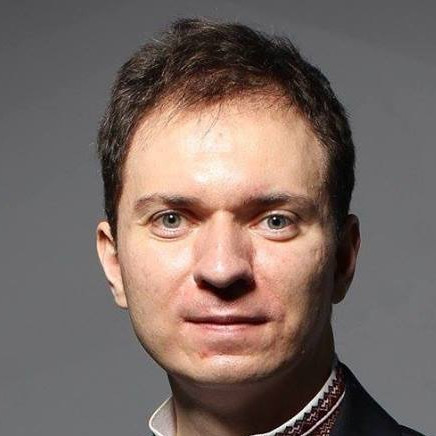

In [21]:
Image(requests.get(s.img['src']).content)

In [22]:
#requests.get(s.img['src']).content